<a href="https://colab.research.google.com/github/rjrockzz/sensor-data-correlation/blob/master/Daily%20Update/har5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pandas==0.20.3
!pip install numba
!pip install umap-learn
!pip install bokeh==0.12.15
!pip install holoviews==1.10.4 
!pip install colorcet
!pip install datashader
! pip install -q scikit-plot
!pip install hyperas
!pip install seq2seq-lstm
!pip install phased-lstm-keras


In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from sklearn import metrics
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
pd.__version__

'0.20.3'

In [0]:
# defining input signals and the labels for activities associated.
all_signals_list = ["body_acc_x_",
                    "body_acc_y_",
                    "body_acc_z_",
                    "body_gyro_x_",
                    "body_gyro_y_",
                    "body_gyro_z_", 
                   "total_acc_x_",
                    "total_acc_y_",
                    "total_acc_z_"]
labels = ["Walking",
          "Upstairs",
          "Downstairs",
          "Sitting",
          "Standing",
          "Laying"]

dataset_path = "/content/drive/My Drive/UCI HAR Dataset"

In [0]:
Training = dataset_path+"/train"  #70% training data
Testing = dataset_path+"/test"    #30% testing data

In [5]:
#Feature extraction
features = list()
with open(dataset_path + "/features.txt") as feature:
    for x in feature:
        features.append(x.split()[1])
ft_df = pd.DataFrame(features)
ft_df.head()

,0
0,tBodyAcc-mean()-X
1,tBodyAcc-mean()-Y
2,tBodyAcc-mean()-Z
3,tBodyAcc-std()-X
4,tBodyAcc-std()-Y


In [6]:
ft_df.tail()

,0
556,"angle(tBodyGyroMean,gravityMean)"
557,"angle(tBodyGyroJerkMean,gravityMean)"
558,"angle(X,gravityMean)"
559,"angle(Y,gravityMean)"
560,"angle(Z,gravityMean)"


In [0]:
#Reading Train Data
train_df = pd.read_csv(dataset_path+"/train/X_train.txt",delim_whitespace=1,names = features)
train_df["person_id"] = pd.read_csv(Training+"/subject_train.txt",header = None, squeeze = True)#adding feature = person_id
#squeeze = True will return data in pandas series format
train_df["activity_id"] = pd.read_csv(Training+"/y_train.txt", header = None, squeeze = True)#adding feature = activity_id
activity_id = pd.read_csv(Training+"/y_train.txt", header = None, squeeze = True)
#mapping activity to activity name
label_name = activity_id.map({1: "WALKING",
                           2:"WALKING_UPSTAIRS",
                           3:"WALKING_DOWNSTAIRS",
                           4:"SITTING",
                           5:"STANDING",
                           6:"LYING"})
train_df["activity"] = label_name

In [106]:
train_df.shape

(7352, 564)

In [0]:
#Reading Test Data
test_df = pd.read_csv(dataset_path+"/test/X_test.txt",delim_whitespace=1,names = features)
test_df["person_id"] = pd.read_csv(Testing+"/subject_test.txt",header = None, squeeze = True)#adding feature = person_id 
test_df["activity_id"] = pd.read_csv(Testing+"/y_test.txt", header = None, squeeze = True)#adding feature = activity_id
activity_id = pd.read_csv(Testing+"/y_test.txt", header = None, squeeze = True)
label_name = activity_id.map({1: "WALKING",
                           2:"WALKING_UPSTAIRS",
                           3:"WALKING_DOWNSTAIRS",
                           4:"SITTING",
                           5:"STANDING",
                           6:"LYING"})
test_df["activity"] = label_name

In [108]:
test_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",person_id,activity_id,activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,5,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,5,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,5,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,5,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,5,STANDING


In [11]:
test_df.shape

(2947, 564)

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


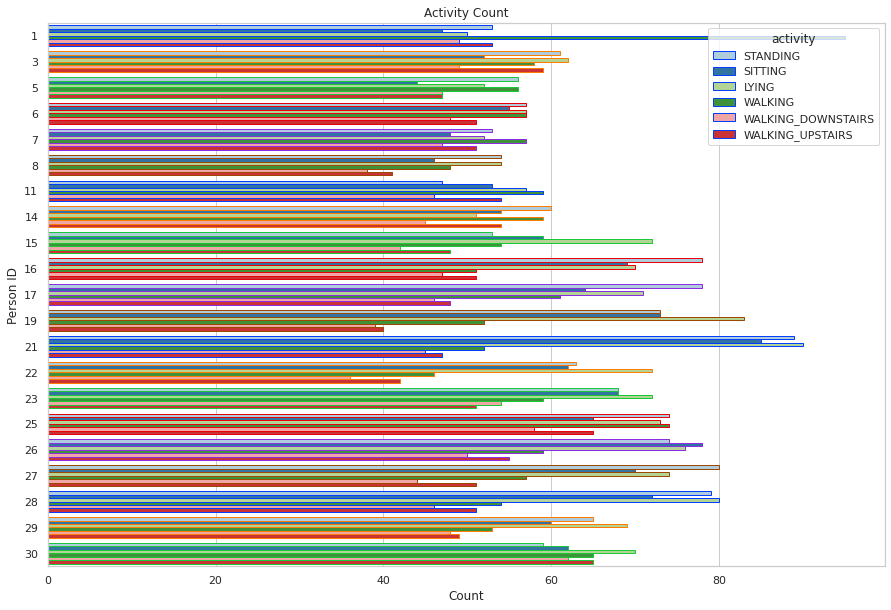

In [0]:
#Checking for any imbalance in the data
import seaborn as sns
%matplotlib inline
sns.set(style="white", palette="Paired", color_codes=True)
sns.set_style("whitegrid") 
fig = plt.figure(figsize=(15,10))
sns.countplot(y="person_id",hue="activity",
              data=train_df,
              edgecolor=sns.color_palette("bright", 6)).set_title("Activity Count")
plt.ylabel("Person ID")
plt.xlabel("Count")
plt.show()

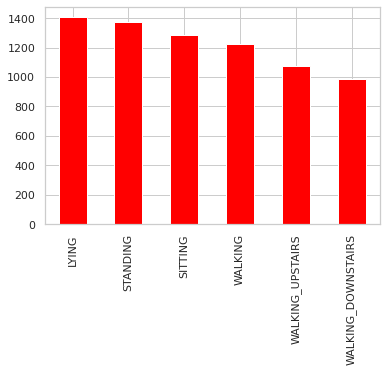

In [0]:
color = train_df["activity_id"].map({1: 'g', 2: 'b', 3: 'y', 4: 'k', 5: 'r', 6: 'g'})
train_df['activity'].value_counts().plot.bar(rot=90,stacked = True, color=color)

In [0]:
train_df.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'person_id',
       'activity_id', 'activity'],
      dtype='object', length=564)

In [12]:
#Feature name changed
columns = train_df.columns
for r in (("[()]", ''), ("-", ''), (",",'')):
    columns = columns.str.replace(*r)
#earlier columns was of type panda Index. Now by writing columns.str it has been changed to pandas string.
#pandas string has a method called replace which we have used here.    
train_df.columns = columns
train_df.columns

Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'angletBodyAccMeangravity', 'angletBodyAccJerkMeangravityMean',
       'angletBodyGyroMeangravityMean', 'angletBodyGyroJerkMeangravityMean',
       'angleXgravityMean', 'angleYgravityMean', 'angleZgravityMean',
       'person_id', 'activity_id', 'activity'],
      dtype='object', length=564)

In [13]:
train_df.columns

Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'angletBodyAccMeangravity', 'angletBodyAccJerkMeangravityMean',
       'angletBodyGyroMeangravityMean', 'angletBodyGyroJerkMeangravityMean',
       'angleXgravityMean', 'angleYgravityMean', 'angleZgravityMean',
       'person_id', 'activity_id', 'activity'],
      dtype='object', length=564)

In [14]:
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

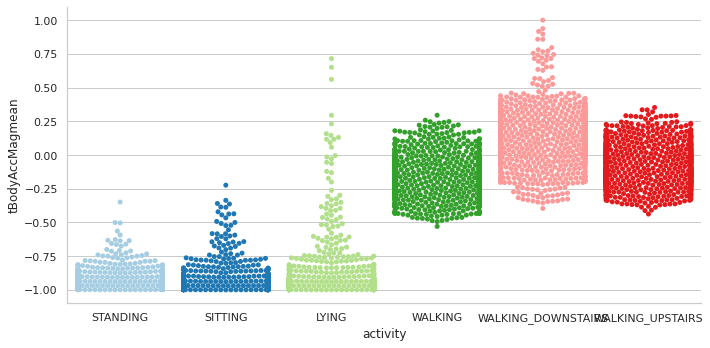

In [0]:
#catplot of the feature body acceleration magnitude mean 
sns.catplot(x="activity", y="tBodyAccMagmean", hue="activity", aspect=2, kind="swarm", data=train_df);



*  If tAccMean is < -0.5 then the Activities are either Standing or Sitting or Laying.
*   If tAccMean is > -0.5 then the Activities are either Walking or Walking Downstairs or Walking Upstairs.
  





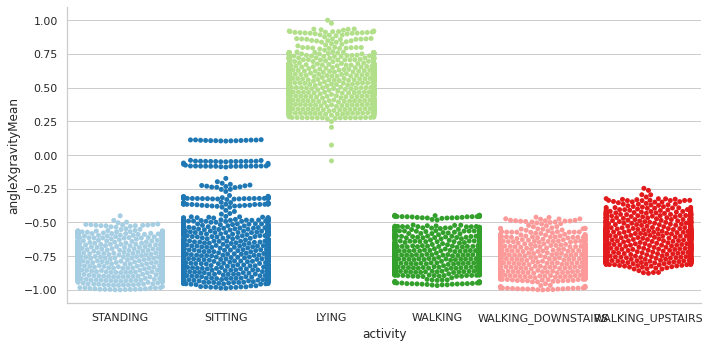

In [0]:
#catplot of the feature acceleration gravity mean on x-axis
sns.catplot(x="activity", y="angleXgravityMean", hue="activity", aspect=2, kind="swarm", data=train_df);



*   If Acc Gravity Mean > 0, we can infer that the activity will most likely be Lying.
*   If Acc Gravity Mean < 0, we can infer that the activity can be anything but Lying.



**Dimensionality Reduction using Uniform Manifold Approximation and Projection**<br>
[UMAP](https://umap-learn.readthedocs.io/en/latest/) Dimensionality Reduction technology used for visualizing as well as  non-linear dimension reduction. The algorithm is founded on three assumptions about the data


1.   The data is uniformly distributed on Riemannian manifold
2.   The Riemannian metric is locally constant (or can be approximated as such).
3.   The manifold is locally connected. 


From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.

 UMAP overall follows the philosophy of tSNE, but introduces a number of improvements such as another cost function and the absence of normalization of high- and low-dimensional probabilities.

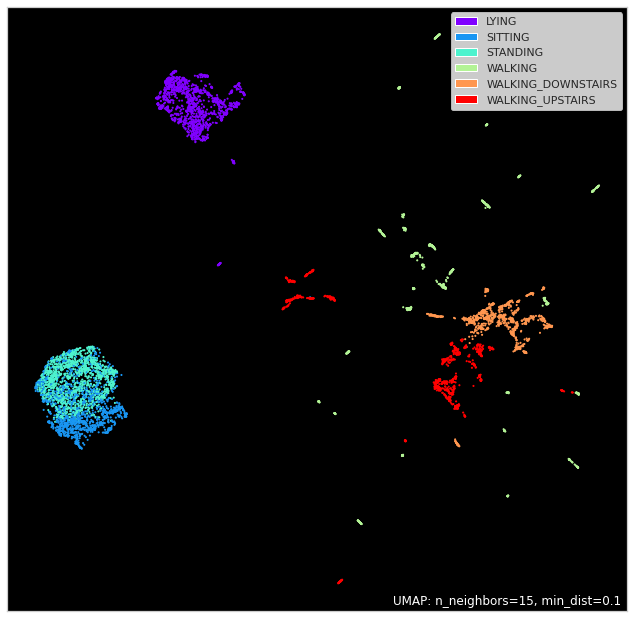

In [0]:
import colorcet
import holoviews
import bokeh
import datashader
import umap
import umap.plot
data = train_df.drop(["person_id", "activity_id", "activity"], axis = 1)
data_label = train_df["activity"]
mapper = umap.UMAP().fit(data)
umap.plot.points(mapper, labels=data_label,theme = 'fire')

**Observations from the UMAP Plot**


The technique can be fairly used to seperate every activity except ***SITTING*** and ***STANDING*** as denoted in the plot.

> # **Machine Learning Modelling**


In [90]:
# Dataset Preparation.
x_train = train_df.drop(["person_id", "activity", "activity_id"], axis = 1)
y_train = train_df["activity"]
x_test = test_df.drop(["person_id", "activity", "activity_id"], axis = 1)
y_test = test_df["activity"]
# 30:70 test:train split ratio.
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7352, 561), (7352,), (2947, 561), (2947,))

>**Logistic Regression**

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import scikitplot as skplt
params = {"C":[0.001,0.01,0.1,1,10**1,10**2,10**3]}
classifier = LogisticRegression(multi_class='ovr',n_jobs=1,solver='liblinear')
cross_val = GridSearchCV(classifier, params, cv=5)
cross_val.fit(x_train, y_train)
predicted = cross_val.predict(x_test)

In [0]:
logistic_accuracy = accuracy_score(y_test, predicted)
logistic_accuracy

0.9619952494061758

In [0]:
logistic_accuracy = 0.9619952494061758

In [0]:
cross_val.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=1, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)>

In [0]:
cross_val.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [0]:
cross_val.best_params_

{'C': 10}

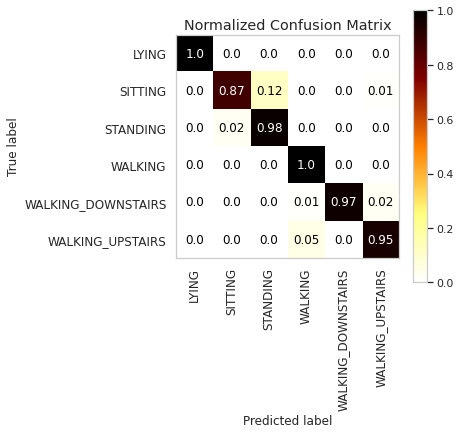

In [0]:
skplt.metrics.plot_confusion_matrix(y_test,predicted,figsize=(5,5),x_tick_rotation=90,cmap='afmhot_r',normalize = True)

> **Gaussian Naive Bayes**

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
params = {}
classifier = GaussianNB()
cross_val = GridSearchCV(classifier,params, cv=skf)
cross_val.fit(x_train, y_train)
predicted1 = cross_val.predict(x_test)

In [0]:
cross_val.cv_results_

{'mean_fit_time': array([0.0604238]),
 'mean_score_time': array([0.02793636]),
 'mean_test_score': array([0.68622678]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.6478586]),
 'split1_test_score': array([0.58531611]),
 'split2_test_score': array([0.80272109]),
 'split3_test_score': array([0.71360544]),
 'split4_test_score': array([0.68163265]),
 'std_fit_time': array([0.0048636]),
 'std_score_time': array([0.00085367]),
 'std_test_score': array([0.07210645])}

In [0]:
gaussian_accuracy = accuracy_score(y_test, predicted1)

In [0]:
gaussian_accuracy

0.7702748557855447

In [0]:
gaussian_accuracy = 0.7702748557855447

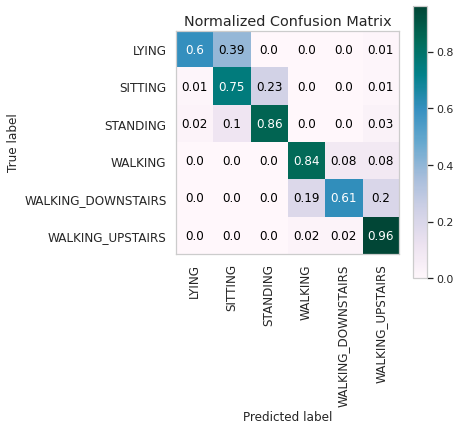

In [0]:
skplt.metrics.plot_confusion_matrix(y_test,predicted1,figsize=(5,5),x_tick_rotation=90,cmap='PuBuGn',normalize = True)

> **Linear SVM**

In [0]:
from sklearn.svm import LinearSVC
params = {"C":[0.001,0.01,0.1,1,10**1,10**2,10**3]}
classifier = LinearSVC(multi_class='ovr',dual=False)
cross_val = GridSearchCV(classifier, params, cv=3)
cross_val.fit(x_train, y_train)
predicted = cross_val.predict(x_test)

In [0]:
linear_svm_accuracy = accuracy_score(y_test, predicted)
linear_svm_accuracy

0.9667458432304038

In [0]:
linear_svm_accuracy = 0.9667458432304038

In [0]:
cross_val.best_estimator_

LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
cross_val.best_params_

{'C': 1}

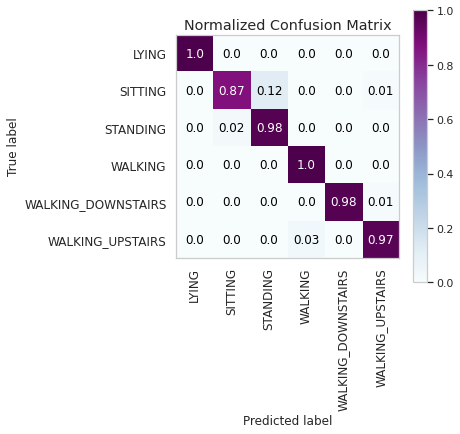

In [0]:
skplt.metrics.plot_confusion_matrix(y_test,predicted,figsize=(5,5),x_tick_rotation=90,cmap='BuPu',normalize = True)

> **RBF SVM** (Radial Basis Function Kernel)

In [0]:
from sklearn.svm import SVC
params = {"C":[0.001,0.01,0.1,1,10**1,10**2,10**3]}
classifier = SVC(kernel='rbf')
cross_val = GridSearchCV(classifier, params, cv=3)
cross_val.fit(x_train, y_train)
predicted = cross_val.predict(x_test)

In [0]:
rbf_svm_accuracy = accuracy_score(y_test, predicted)
rbf_svm_accuracy

0.9653885307091958

In [0]:
rbf_svm_accuracy = 0.9653885307091958

In [0]:
cross_val.best_estimator_

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
cross_val.best_params_

{'C': 100}

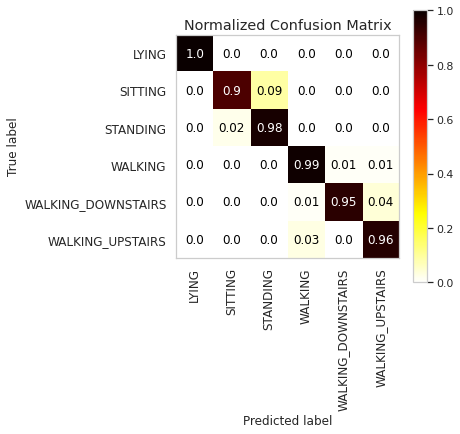

In [0]:
skplt.metrics.plot_confusion_matrix(y_test,predicted,figsize=(5,5),x_tick_rotation=90,cmap='hot_r',normalize = True)

> **Decision Tree**

In [0]:
from sklearn.tree import DecisionTreeClassifier
params = {"max_depth": [2, 3, 4, 5, 6, 7, 8]}
classifier = DecisionTreeClassifier()
cross_val = GridSearchCV(classifier, params, cv=5)
cross_val.fit(x_train, y_train)
predicted = cross_val.predict(x_test)

In [0]:
decision_tree_accuracy = accuracy_score(y_test, predicted)
decision_tree_accuracy

0.8727519511367492

In [0]:
decision_tree_accuracy = 0.8727519511367492

In [0]:
cross_val.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
cross_val.best_params_

{'max_depth': 8}

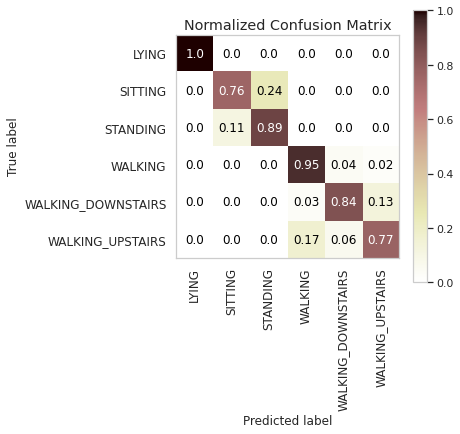

In [0]:
skplt.metrics.plot_confusion_matrix(y_test,predicted,figsize=(5,5),x_tick_rotation=90,cmap='pink_r',normalize = True)

> **Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier
params = {"n_estimators": [50, 100, 200, 400]}
classifier = RandomForestClassifier()
cross_val = GridSearchCV(classifier, params, cv=3)
cross_val.fit(x_train, y_train)
predicted = cross_val.predict(x_test)

In [0]:
random_forest_accuracy = accuracy_score(y_test, predicted)
random_forest_accuracy

0.8727519511367492

In [0]:
random_forest_accuracy = 0.8727519511367492

In [0]:
cross_val.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
cross_val.best_params_

{'max_depth': 8}

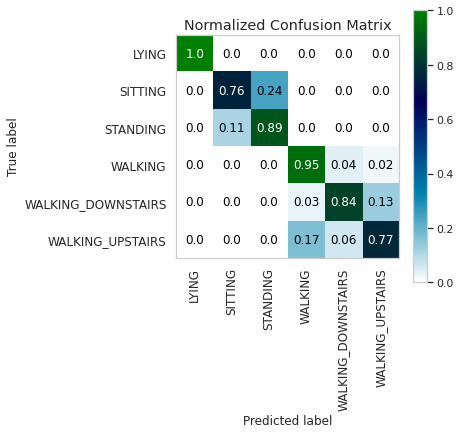

In [0]:
skplt.metrics.plot_confusion_matrix(y_test,predicted,figsize=(5,5),x_tick_rotation=90,cmap='ocean_r',normalize = True)

> **Gradient Boosting**

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
params = {"n_estimators": [20,30], "max_depth":[1, 1.5]}
classifier = GradientBoostingClassifier()
cross_val = GridSearchCV(classifier, params, cv=3)
cross_val.fit(x_train, y_train)
predicted = cross_val.predict(x_test)
gradient_boosted_accuracy = accuracy_score(y_test, predicted)

In [0]:
gradient_boosted_accuracy

0.8734306073973532

In [0]:
gradient_boosted_accuracy = 0.8734306073973532

In [0]:
cross_val.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

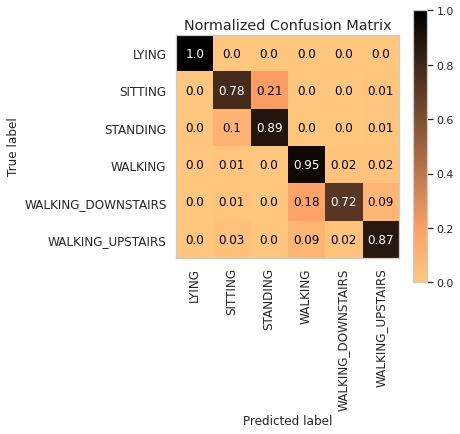

In [0]:
skplt.metrics.plot_confusion_matrix(y_test,predicted,figsize=(5,5),x_tick_rotation=90,cmap='copper_r',normalize = True)

In [0]:
Model=["Logistic Regression", "Gaussian NB", "Linear SVM", "RBF SVM", "Decision Tree", "Random Forest", "Gradient Boosting"]
Accuracy=[logistic_accuracy*100,gaussian_accuracy*100,linear_svm_accuracy*100,rbf_svm_accuracy*100,decision_tree_accuracy*100,random_forest_accuracy*100,gradient_boosted_accuracy*100]
df = pd.DataFrame(dict(Model=Model, Accuracy=Accuracy))
df

,Accuracy,Model
0,96.199525,Logistic Regression
1,77.027486,Gaussian NB
2,96.674584,Linear SVM
3,96.538853,RBF SVM
4,87.275195,Decision Tree
5,87.275195,Random Forest
6,87.343061,Gradient Boosting


In [0]:
sns.catplot("Model","Accuracy", data=df ,palette="dark",aspect=2,kind="bar")

# **Deep Learning Modelling**
> We'll be using 128 sized raw readings obtained from accelerometers and the gyrometers.


In [0]:
# Xtrain Readings
x_train_dl = []
for signal in all_signals_list:
  x_train_dl.append(reading_data("/content/drive/My Drive/UCI HAR Dataset/train/Inertial Signals/"+ signal + "train.txt").as_matrix())

In [69]:
x_train_dl = np.array(x_train_dl)
print("Before transformation Xtrain shape : ",x_train_dl.shape)
x_train_dl = np.transpose(x_train_dl,(1,2,0))
print("After transformation Xtrain shape : ", x_train_dl.shape)

Before transformation Xtrain shape :  (9, 7352, 128)
After transformation Xtrain shape :  (7352, 128, 9)


Xtrain data interpretation:
> 7352 : no. of samples.<br>
> 128 : raw readings from the sensor for each sample.<br>
> 9 : the number of signals (check all_signals_list) in the dataset.


In [0]:
# Xtest Readings
x_test_dl = []
for signal in all_signals_list:
  x_test_dl.append(reading_data("/content/drive/My Drive/UCI HAR Dataset/test/Inertial Signals/"+ signal + "test.txt").as_matrix())

In [79]:
x_test_dl = np.array(x_test_dl)
print("Before transformation Xtest shape : ",x_test_dl.shape)
x_test_dl = np.transpose(x_test_dl,(1,2,0))
print("After transformation Xtest shape : ", x_test_dl.shape)

Before transformation Xtest shape :  (9, 2947, 128)
After transformation Xtest shape :  (2947, 128, 9)


Xtest data interpretation:
> 2947 : no. of samples.<br>
> 128 : raw readings from the sensor for each sample.<br>
> 9 : the number of signals (check all_signals_list) in the dataset.


In [0]:
y_train = train_df["activity_id"]
y_test = test_df["activity_id"]
y_train_dl = pd.get_dummies(y_train).as_matrix()
y_test_dl = pd.get_dummies(y_test).as_matrix()

> ytrain and ytest have been converted into dummy/indicator variables (pandas version of one-hot-encoder).

In [122]:
x_train_dl.shape, y_train_dl.shape,x_test_dl.shape,y_test_dl.shape

((7352, 128, 9), (7352, 6), (2947, 128, 9), (2947, 6))